In [1]:
device = 'cuda:1'

In [2]:
import numpy as np

# Generate trajectory (3 timestep traj for now -> generalize into T timestep)
def get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio=None, scale=0.1):
    assert type(scale) in {float, int} or len(scale) == len(start_loc_org)
    
    xp = np.linspace(0, 1, len(intersection_point)+2)
    
    inter_point = np.stack([start_loc_org, *intersection_point, target_loc_org], axis=0)

    if ratio is None:
        ratio = xp
    
    ref_trajectory = np.stack([np.interp(ratio, xp, inter_point[:, 0]), np.interp(ratio, xp, inter_point[:, 1])], axis=1)
    ref_trajectory = ref_trajectory + scale * np.random.randn(*ref_trajectory.shape)
    
    return ref_trajectory

(128, 16)


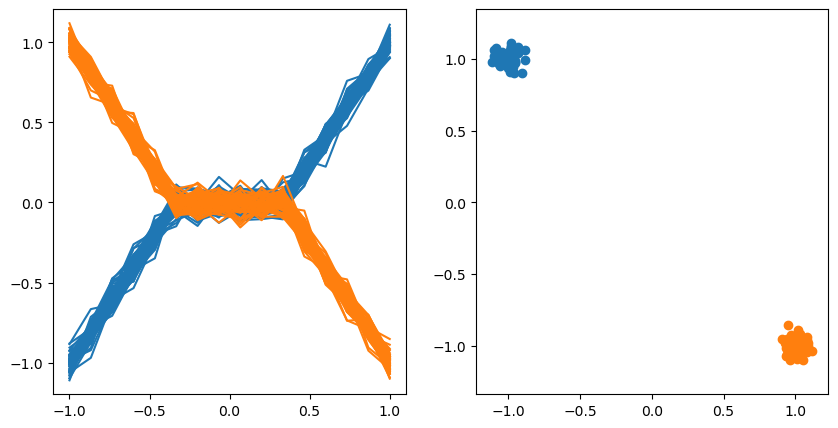

In [3]:
# Plot the trajectory and its datapoint on R^T space
def get_data(num_trajectories):
        
    # print(f"[ environments/maze2d ] getting dataset for {dataname}")
    
    # dataset = collections.defaultdict(list)            
    # for key in ['observations', 'actions', 'rewards', 'terminals', 'info/goal', 'info/qpos', 'info/qvel']:
    #     dataset[key] = []
    
    intersection_point = [[-3.33, 0], [3.33, 0]]
    # intersection_point = [[0, 0]]

    ratio = np.linspace(0, 1, 16)
    
    scale = 0.05

    start_loc_org = np.array([-1, -1], dtype=float)
    target_loc_org = np.array([1, 1], dtype=float)
    
    trajectories_lst = []
    for _ in range(num_trajectories//2):
        ref_trjectory = get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio, scale=scale)
        trajectories_lst.append(ref_trjectory)

    start_loc_org = np.array([-1, 1], dtype=float)
    target_loc_org = np.array([1, -1], dtype=float)
    
    for _ in range(num_trajectories//2):
        ref_trjectory = get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio, scale=scale)
        trajectories_lst.append(ref_trjectory)
        
    start_loc_org = np.array([-1, 0], dtype=float)
    target_loc_org = np.array([1, 0], dtype=float)
    
    # for _ in range(num_trajectories//3):
    #     ref_trjectory = get_ref_trajectory(start_loc_org, target_loc_org, intersection_point, ratio, scale=scale)
    #     trajectories_lst.append(ref_trjectory)

    trajectories = np.stack(trajectories_lst)[:, :, 1]
    
    return trajectories

from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

trajectories = get_data(128)
print(trajectories.shape)

x = np.repeat(np.expand_dims(np.linspace(-1, 1, trajectories.shape[1]), axis=0), [trajectories.shape[0]], axis=0)
ax[0].plot(x[:trajectories.shape[0]//2, :].T, trajectories[:trajectories.shape[0]//2, :].T, c='tab:blue');
ax[0].plot(x[trajectories.shape[0]//2:, :].T, trajectories[trajectories.shape[0]//2:, :].T, c='tab:orange');
ax[0].axis('equal');

def extract_dimension(array, dim_lst):
    return array[:, dim_lst]

trajectories = extract_dimension(trajectories, [0, -1])
ax[1].scatter(trajectories[:trajectories.shape[0]//2, 0], trajectories[:trajectories.shape[0]//2, 1])
ax[1].scatter(trajectories[trajectories.shape[0]//2:, 0], trajectories[trajectories.shape[0]//2:, 1])
ax[1].axis('equal');

In [4]:
# implement DSM
import torch
from torch.autograd import grad
from torch import nn

# Score Estimation Network
class EnergyNet(nn.Module):
    def __init__(self, input_dim=3, hidden_dim = 256, normalize = 'default'):
        super().__init__()
        self.foward_1 = nn.Linear(input_dim, hidden_dim)
        self.foward_2 = nn.Linear(hidden_dim, hidden_dim)
        self.foward_3 = nn.Linear(hidden_dim, 1)

        if normalize == 'default':
            def normalize(x):
                return x
        elif normalize == 'batch_norm':
            self.batch_norm_layer = nn.BatchNorm1d(num_features=2)
            def normalize(x):
                return self.batch_norm_layer(x)
        elif normalize == 'standard':
            def normalize(x):
                norm_min, norm_max = x.min().clone().detach(), x.max().clone().detach()
                normalized_data = (x - norm_min)/(norm_max-norm_min)
                norm_mean = normalized_data.mean().clone().detach()
                normalized_data = normalized_data - norm_mean

                return normalized_data
        else:
            raise NotImplementedError
        self.normalize = normalize

    def forward(self, x):
        # print(x.shape)
        x = self.normalize(x)
        # print(x.shape)
        self.normalized_data = x.clone().detach()
        x = nn.GELU()(self.foward_1(x))
        x = nn.GELU()(self.foward_2(x))
        x = (self.foward_3(x))
        
        return x
    
# LangevinSampler
class LangevinSampler:
    """Langevin Monte Carlo Sampler"""
    def __init__(self, n_step, stepsize, noise_std):
        self.n_step = n_step
        self.stepsize = stepsize
        self.noise_std = noise_std

    def sample(self, x_init, energy_fn):
        x = x_init.clone()
        x.requires_grad = True
        for i_step in range(self.n_step):
            energy = energy_fn(x)
            g = grad(energy.sum(), x, create_graph=True)[0]
            x = x - self.stepsize * g + torch.randn_like(x) * self.noise_std
        return x.detach()
    
    def sample_from_score(self, x_init, score_fn):
        x = x_init.clone()
        for i_step in range(self.n_step):
            score = score_fn(x)
            x = x + self.stepsize * score + torch.randn_like(x) * self.noise_std
        return x.detach()

In [5]:
from torch.optim import Adam

# Bring score estimation model
trajectories = get_data(4)
energy_model = EnergyNet(input_dim=trajectories.shape[1], hidden_dim=128).to(device=device)

# Bring optimizer
opt = Adam(energy_model.parameters(), lr=0.0001)

# Bring LangevinSampler
langevin_sampler = LangevinSampler(n_step=1000, stepsize=0.01, noise_std=0.05)

In [6]:
# Train score model
from tqdm import tqdm

sigma = 0.1
batch_size = 128
training_step = 10000

loss_lst = []

loss_lst_lst = []
sampled_trajectories_lst = []
sampled_vectorfield_lst = []

for i in tqdm(range(training_step)):
    opt.zero_grad()

    # get noised data
    train_data = torch.from_numpy(get_data(batch_size)).to(dtype=torch.float32).to(device=device)
    noise_z = np.random.multivariate_normal(np.zeros(train_data.shape[1]), cov=np.eye(train_data.shape[1]), size=train_data.shape[0])
    noise_z = torch.tensor(noise_z, dtype=torch.float).to(device=device)
    train_data_noise = train_data + sigma * noise_z
    train_data_noise.requires_grad = True

    energy = energy_model(train_data_noise)

    score = -grad(energy.sum(), train_data_noise, create_graph=True)[0]

    loss = torch.norm(noise_z/sigma + score, dim=-1)**2
    loss = 1/2 * loss.mean()
    
    loss.backward()
    opt.step()
    loss_lst.append(loss.clone().detach().cpu().item())

    if i % (training_step//5) == 0:
        loss_lst_lst.append(loss_lst.copy())

        # sample data
        x0 = torch.randn_like(train_data)
        sampled_trajectories = langevin_sampler.sample(x0, energy_model)
        sampled_trajectories_lst.append(sampled_trajectories.clone().detach().cpu().numpy())

100%|██████████| 10000/10000 [00:47<00:00, 211.45it/s]


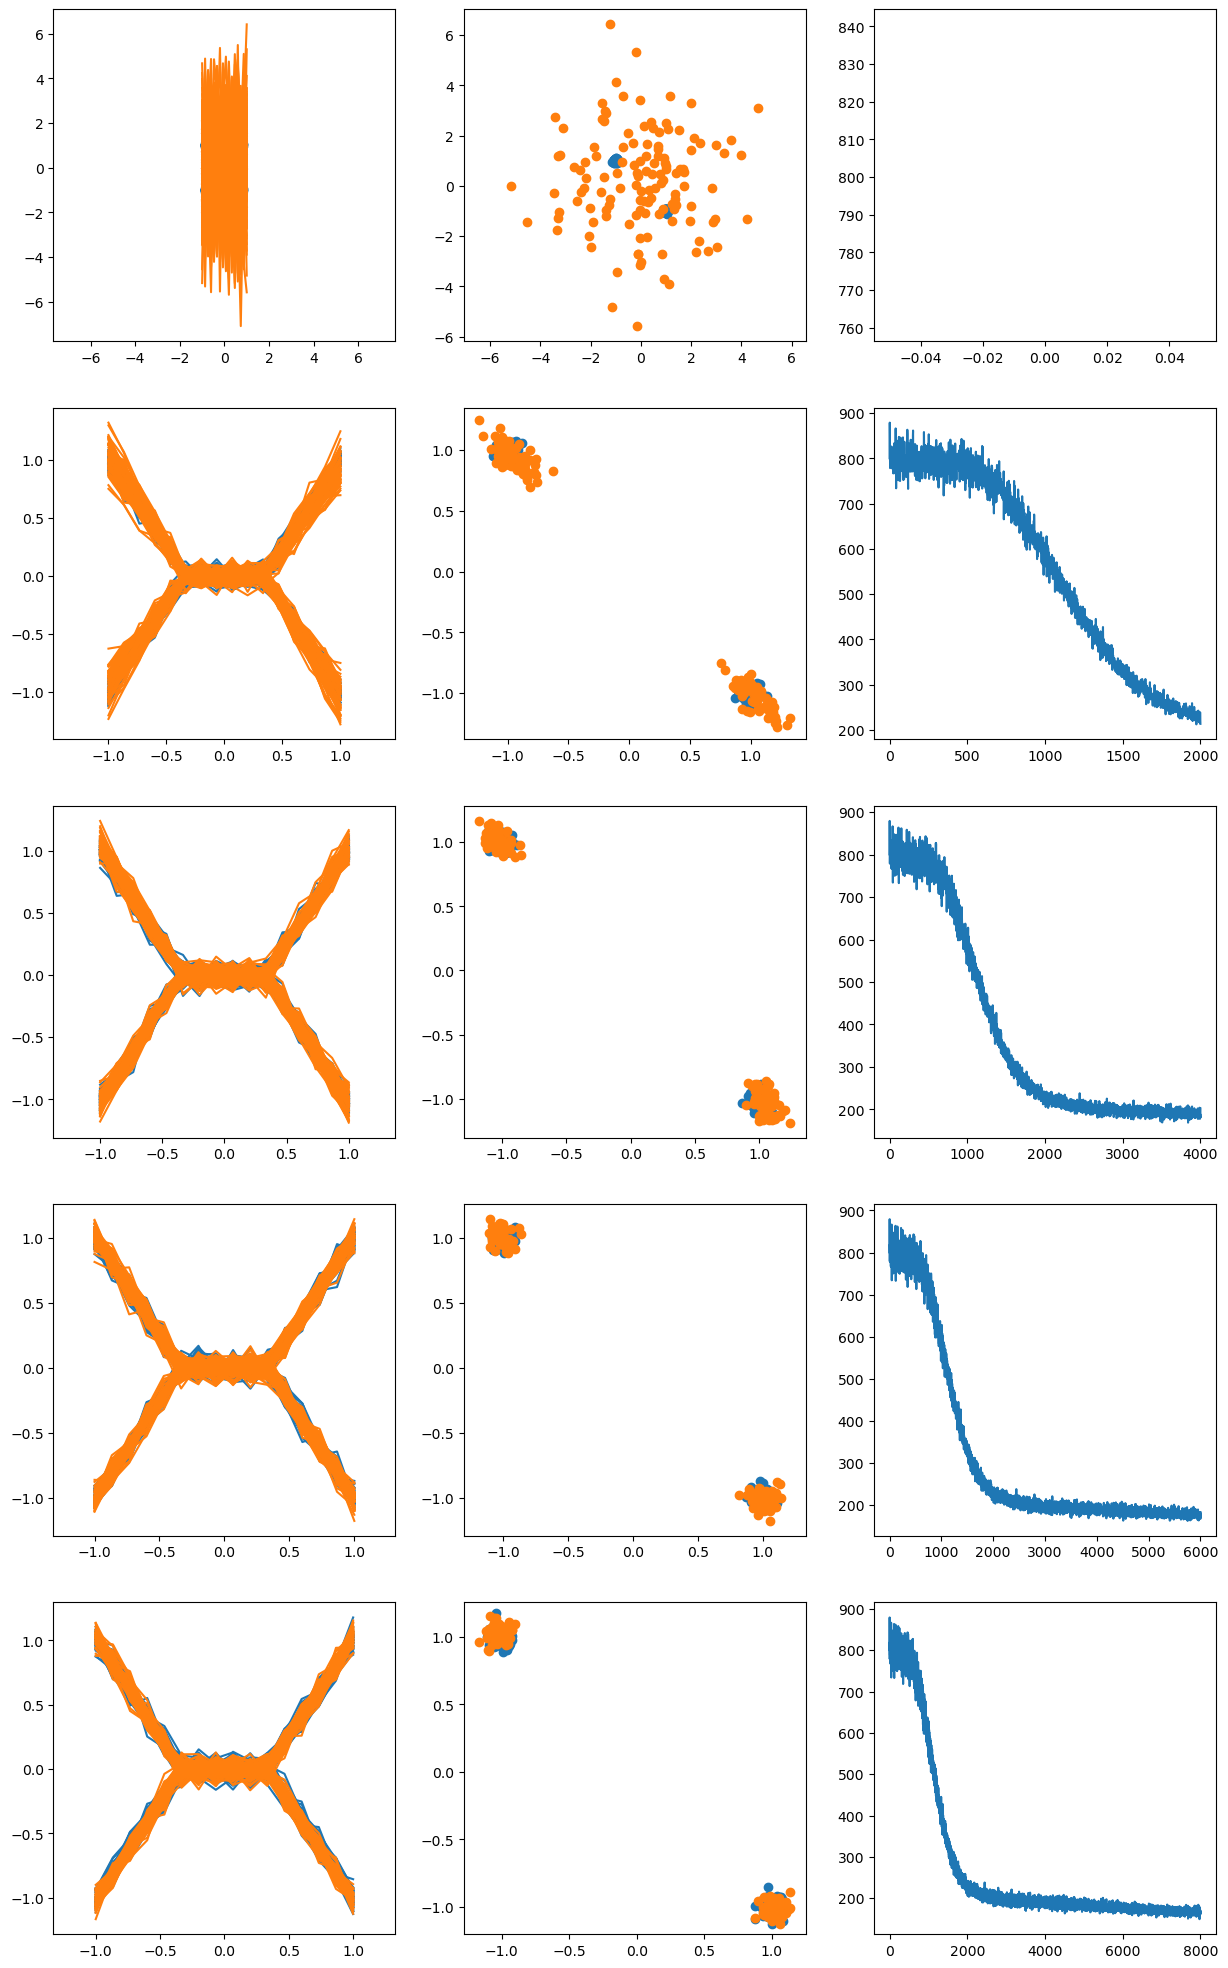

In [7]:
# Plot the sampled trajectory and its datapoit on R^T space

fig, ax = plt.subplots(len(loss_lst_lst), 3, figsize=(15, 5*len(loss_lst_lst)))

for i, (loss_lst, sampled_trajectories) in enumerate(zip(loss_lst_lst, sampled_trajectories_lst)):

    x = np.repeat(np.expand_dims(np.linspace(-1, 1, sampled_trajectories.shape[1]), axis=0), [sampled_trajectories.shape[0]], axis=0)
    trajectories = get_data(sampled_trajectories.shape[0])

    ax[i, 0].plot(x.T, trajectories.T, c='tab:blue');
    ax[i, 0].plot(x.T, sampled_trajectories.T, c='tab:orange');
    ax[i, 0].axis('equal');
    axis = [0, -1]
    
    sampled_trajectories_ = extract_dimension(sampled_trajectories, axis)
    trajectories_ = extract_dimension(trajectories, axis)

    ax[i, 1].scatter(trajectories_[:, 0], trajectories_[:, 1])
    ax[i, 1].scatter(sampled_trajectories_[:, 0], sampled_trajectories_[:, 1])
    ax[i, 1].axis('equal')
    
    ax[i, 2].plot(loss_lst)

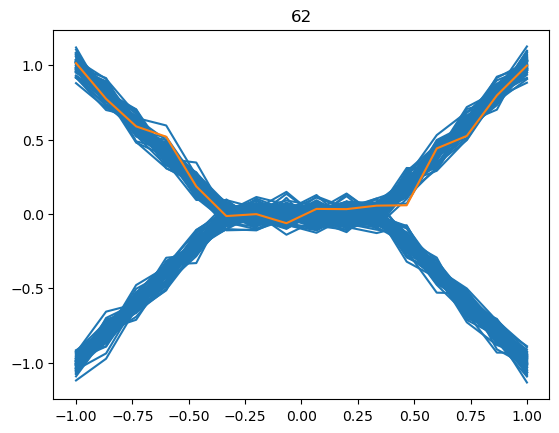

In [38]:
x = np.repeat(np.expand_dims(np.linspace(-1, 1, sampled_trajectories.shape[1]), axis=0), [sampled_trajectories.shape[0]], axis=0)
n = int(np.random.uniform(0, len(sampled_trajectories)))
plt.plot(x.T, trajectories.T, c='tab:blue');
plt.plot(x[0], sampled_trajectories[n], c='tab:orange');
plt.title(n);

In [9]:
# Time embedding EnergyNet
import math

class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

class TimeEmbeddedEnergyNet(nn.Module):
    def __init__(self, input_dim=3, time_dim=32, hidden_dim = 256):
        super().__init__()
        self.foward_1 = nn.Linear(input_dim, hidden_dim)
        self.foward_2 = nn.Linear(hidden_dim, hidden_dim)
        self.foward_3 = nn.Linear(hidden_dim, 1)
        
        self.time_mlp = nn.Sequential(
            # nn.Linear(1, time_dim),
            SinusoidalPosEmb(time_dim),
            nn.Linear(time_dim, time_dim * 4),
            nn.Mish(),
            nn.Linear(time_dim * 4, hidden_dim),
        )
        
    def forward(self, x, t):
        # t = t.to(dtype=torch.float32)
        time_emb = self.time_mlp(t).squeeze()
        x = self.foward_1(x)
        x = x + time_emb
        
        x = nn.GELU()(self.foward_2(x))
        # x = nn.GELU()(self.foward_2(x))
        x = (self.foward_3(x))
        
        return x

In [10]:
# implment time embedded Stitched DSM
# Now we only need 2 networks 1. joint energy model, 2. marginal energy model
joint_energy_model = TimeEmbeddedEnergyNet(input_dim=2).to(device=device)
marginal_energy_model = TimeEmbeddedEnergyNet(input_dim=1).to(device=device)

# Bring optimizer
opt = Adam([*joint_energy_model.parameters(), *marginal_energy_model.parameters()], lr=0.0001)

# Bring LangevinSampler
langevin_sampler = LangevinSampler(n_step=1000, stepsize=0.01, noise_std=0.05)

In [11]:
# Train score model
from tqdm import tqdm

sigma = 0.1
batch_size = 128
training_step = 10000

stitch_loss_lst = []

stitch_loss_lst_lst = []
stitch_sampled_trajectories_lst = []

for i in tqdm(range(training_step)):
    opt.zero_grad()

    # get noised data
    train_data = torch.from_numpy(get_data(batch_size)).to(dtype=torch.float32).to(device=device)
    T = train_data.shape[1]
    noise_z = np.random.multivariate_normal(np.zeros(train_data.shape[1]), cov=np.eye(train_data.shape[1]), size=train_data.shape[0])
    noise_z = torch.tensor(noise_z, dtype=torch.float).to(device=device)
    train_data_noise = train_data + sigma * noise_z
    
    loss = 0
    
    time = torch.arange(T-1).repeat(train_data.shape[0]).unsqueeze(1).to(device=device)
    joint_energy_model_input = torch.stack([train_data_noise[:, :-1], train_data_noise[:, 1:]], dim=-1).reshape(-1, 2).requires_grad_()
    joint_energy = joint_energy_model(joint_energy_model_input, time)
    joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0]
    joint_noise = torch.stack([noise_z[:, :-1], noise_z[:, 1:]], dim=-1).reshape(-1, 2)
    joint_loss = torch.norm(joint_noise/sigma + joint_score, dim=-1)**2
    loss += 1/2 * joint_loss.mean()
    
    marginal_energy_input = train_data_noise[:, :-1].reshape(-1, 1).requires_grad_()
    marginal_energy = marginal_energy_model(marginal_energy_input, time)
    marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0]
    marginal_noise = noise_z[:, :-1].reshape(-1, 1)
    marginal_loss = torch.norm(marginal_noise/sigma + marginal_score, dim=-1)**2
    loss += 1/2 * marginal_loss.mean()
    
    loss.backward()
    opt.step()
    stitch_loss_lst.append(loss.clone().detach().cpu().item())
    
    if i % (training_step//5) == 0:
        stitch_loss_lst_lst.append(stitch_loss_lst.copy())

        ## sample data
        x0 = torch.randn_like(train_data)
        
        def get_score(x):
            batch_size = x.shape[0]
            T = x.shape[1]
            
            total_score = torch.zeros_like(x).to(x.device)
            
            time = torch.arange(T-1).repeat(batch_size).unsqueeze(1).to(device=device)
            
            joint_energy_model_input = torch.stack([x[:, :-1], x[:, 1:]], dim=-1).reshape(batch_size * (T-1), 2).requires_grad_()
            joint_energy = joint_energy_model(joint_energy_model_input, time)
            joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0].reshape(batch_size, -1, 2)
            
            total_score[:, :-1] += joint_score[:, :, 0]
            total_score[:, 1:] += joint_score[:, :, 1]
            
            marginal_energy_input = x[:, :-1].reshape(batch_size * (T-1), 1).clone().requires_grad_()
            marginal_energy = marginal_energy_model(marginal_energy_input, time)
            marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0].reshape(batch_size, -1)
            
            total_score[:, 1:-1] -= marginal_score[:, 1:]
            
            return total_score.detach()
        
        stitch_sampled_trajectories = langevin_sampler.sample_from_score(x0, get_score)
        stitch_sampled_trajectories_lst.append(stitch_sampled_trajectories.clone().detach().cpu().numpy())

100%|██████████| 10000/10000 [01:06<00:00, 151.03it/s]


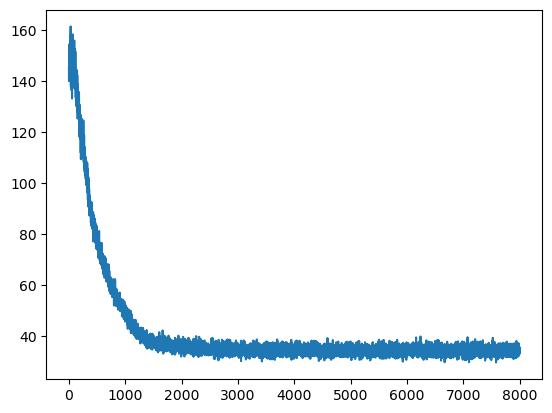

In [12]:
plt.plot(stitch_loss_lst_lst[-1])

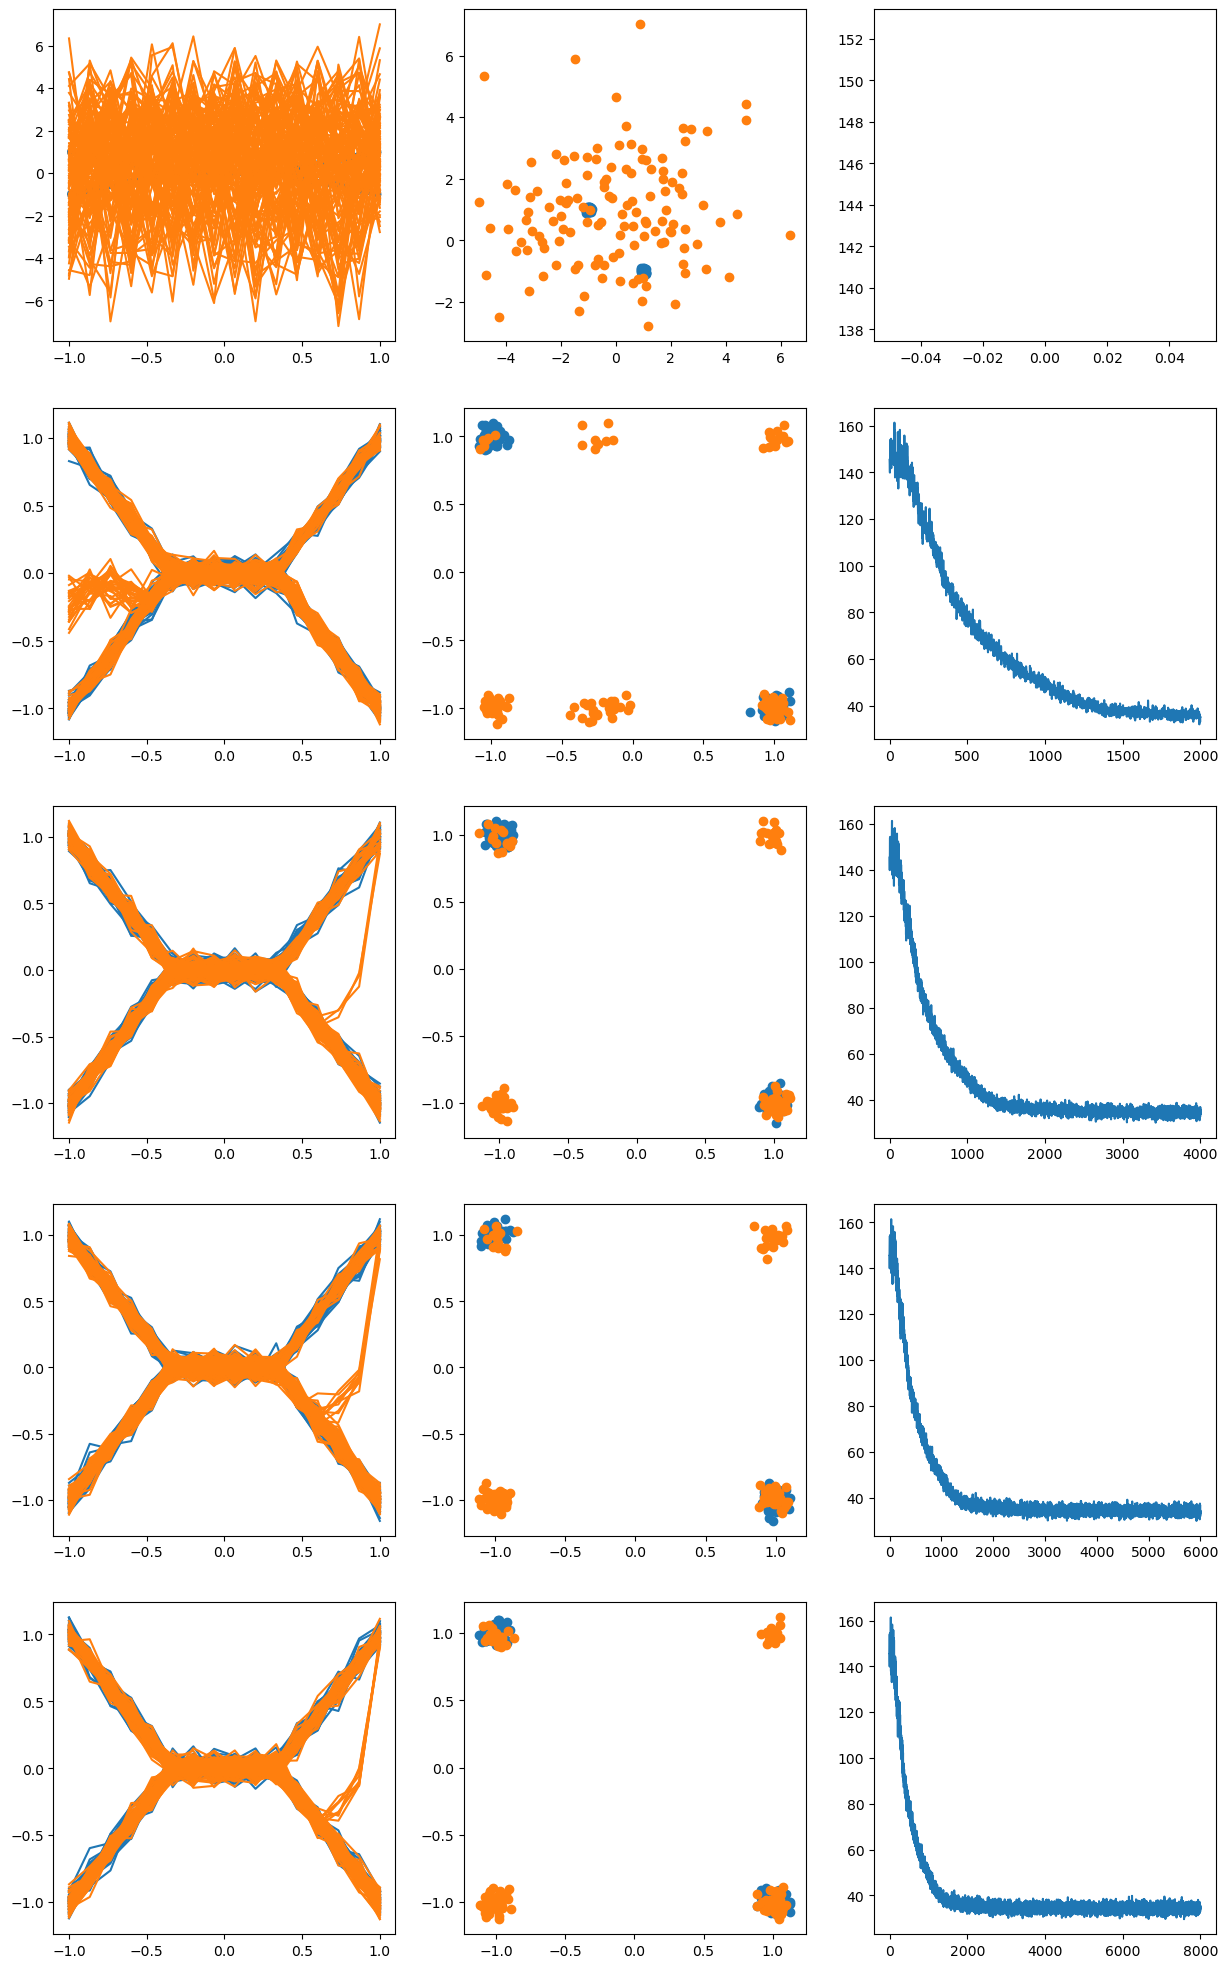

In [30]:
# Plot the sampled trajectory and its datapoit on R^T space
fig, ax = plt.subplots(len(stitch_loss_lst_lst), 3, figsize=(15, 5*len(stitch_loss_lst_lst)))

for i, (loss_lst, sampled_trajectories) in enumerate(zip(stitch_loss_lst_lst, stitch_sampled_trajectories_lst)):

    num = 0
    x = np.repeat(np.expand_dims(np.linspace(-1, 1, sampled_trajectories.shape[1]), axis=0), [sampled_trajectories.shape[0]], axis=0)[num:]
    trajectories = get_data(sampled_trajectories.shape[0])[num:]
    sampled_trajectories = sampled_trajectories[num:]

    ax[i, 0].plot(x.T, trajectories.T, c='tab:blue');
    ax[i, 0].plot(x.T, sampled_trajectories.T, c='tab:orange');
    # ax[i, 0].axis('equal')
    # ax[i, 0].set_xlim(-1.5, 1.5)
    # ax[i, 0].set_ylim(-1.5, 1.5)
    axis = [0, -1]
    
    sampled_trajectories_ = extract_dimension(sampled_trajectories, axis)
    trajectories_ = extract_dimension(trajectories, axis)

    ax[i, 1].scatter(trajectories_[:, 0], trajectories_[:, 1])
    ax[i, 1].scatter(sampled_trajectories_[:, 0], sampled_trajectories_[:, 1])
    # ax[i, 1].axis('equal')
    # ax[i, 1].set_xlim(-1.5, 1.5)
    # ax[i, 1].set_ylim(-1.5, 1.5)
    
    ax[i, 2].plot(loss_lst)


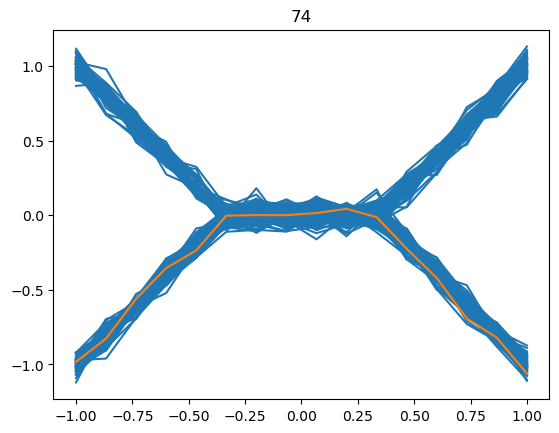

In [14]:
x = np.repeat(np.expand_dims(np.linspace(-1, 1, sampled_trajectories.shape[1]), axis=0), [sampled_trajectories.shape[0]], axis=0)
n = int(np.random.uniform(0, len(sampled_trajectories)))
plt.plot(x.T, trajectories.T, c='tab:blue');
plt.plot(x[0], sampled_trajectories[n], c='tab:orange');
plt.title(n);

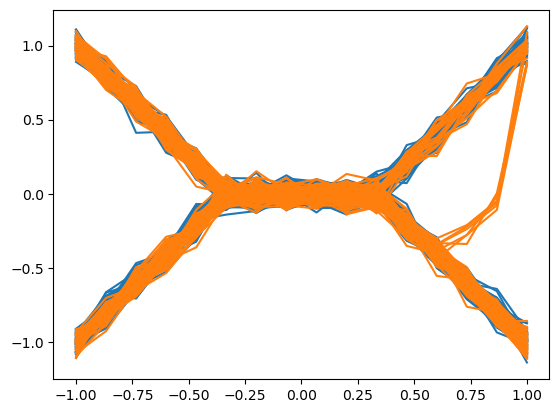

In [29]:
# Plot sampled trajectory
x0 = torch.randn_like(train_data)[:100]

langevin_sampler = LangevinSampler(n_step=5000, stepsize=0.01, noise_std=0.05)

def get_score(x):
    batch_size = x.shape[0]
    T = x.shape[1]
    
    total_score = torch.zeros_like(x).to(x.device)
    
    time = torch.arange(T-1).repeat(batch_size).unsqueeze(1).to(device=device)
    
    joint_energy_model_input = torch.stack([x[:, :-1], x[:, 1:]], dim=-1).reshape(batch_size * (T-1), 2).requires_grad_()
    joint_energy = joint_energy_model(joint_energy_model_input, time)
    joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0].reshape(batch_size, -1, 2)
    
    total_score[:, :-1] += joint_score[:, :, 0]
    total_score[:, 1:] += joint_score[:, :, 1]
    
    marginal_energy_input = x[:, :-1].reshape(batch_size * (T-1), 1).clone().requires_grad_()
    marginal_energy = marginal_energy_model(marginal_energy_input, time)
    marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0].reshape(batch_size, -1)
    
    total_score[:, 1:-1] -= marginal_score[:, 1:]
    
    return total_score.detach()

stitch_sampled_trajectories = langevin_sampler.sample_from_score(x0, get_score).detach().cpu().numpy()

plt.plot(x.T, trajectories.T, c='tab:blue');
plt.plot(x[:x0.shape[0]].T, stitch_sampled_trajectories.T, c='tab:orange');

100%|██████████| 15/15 [00:36<00:00,  2.42s/it]


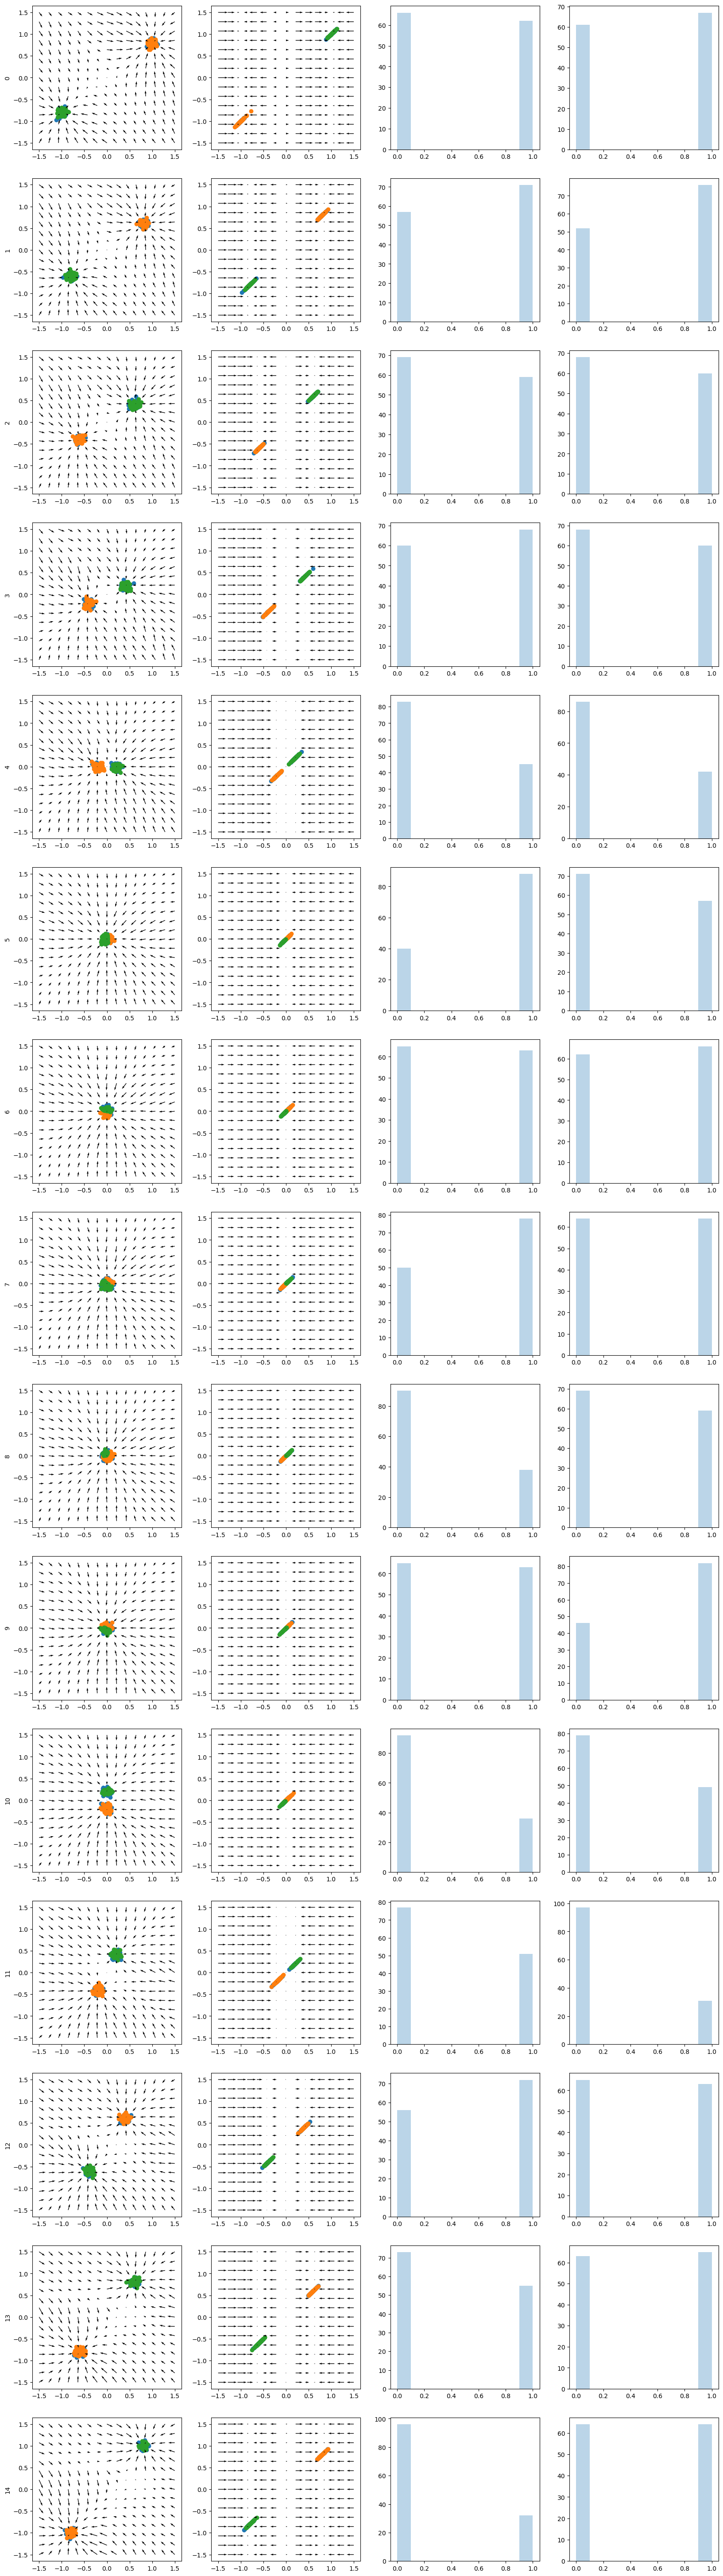

In [33]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

trajectories = get_data(128)

# Bring LangevinSampler
langevin_sampler_validate = LangevinSampler(n_step=1000, stepsize=0.01, noise_std=0.05)
T = trajectories.shape[1]

fig, ax = plt.subplots(T-1, 4, figsize=(20, 5* (T-1)))

for t in tqdm(range(T-1)):

    trajectories_slice = trajectories[:, [t, t+1]]

    # sample data
    x0 = torch.randn_like(torch.tensor(trajectories_slice, dtype=torch.float32)).to(device=device)

    def get_joint_score(x):
        batch_size = x.shape[0]
        time = torch.tensor(t).repeat(batch_size).unsqueeze(1).to(device=device)
        
        joint_energy_model_input = x.clone().requires_grad_()
        joint_energy = joint_energy_model(joint_energy_model_input, time)
        joint_score = -grad(joint_energy.sum(), joint_energy_model_input, create_graph=True)[0]

        return joint_score.clone().detach()

    def get_marginal_score(x):
        batch_size = x.shape[0]
        time = torch.tensor(t).repeat(batch_size).unsqueeze(1).to(device=device)
        
        marginal_energy_input = x.clone().requires_grad_()
        marginal_energy = marginal_energy_model(marginal_energy_input, time)
        marginal_score = -grad(marginal_energy.sum(), marginal_energy_input, create_graph=True)[0]

        return marginal_score.clone().detach()

    sampled_joint_datapoint = langevin_sampler_validate.sample_from_score(x0, get_joint_score).clone().detach().cpu().numpy()

    sampled_marginal_datapoint = langevin_sampler_validate.sample_from_score(x0[:, 0:1], get_marginal_score).clone().detach().cpu().numpy()
    
    joint_kmeans_idx = GaussianMixture(n_components=2).fit_predict(sampled_joint_datapoint)
    marginal_kmeans_idx = GaussianMixture(n_components=2).fit_predict(sampled_marginal_datapoint)

    x_lim = [-1.5, 1.5]
    y_lim = [-1.5, 1.5]
    x_grid, y_grid = np.meshgrid(np.linspace(*x_lim, 15), np.linspace(*y_lim, 15))
    
    grid_input = torch.tensor(np.stack([x_grid, y_grid], axis=-1).reshape((-1, 2)), dtype=torch.float32, device=device)
    score = get_joint_score(grid_input).reshape((*x_grid.shape, 2)).cpu().numpy()
    ax[t][0].scatter(trajectories_slice[:, 0], trajectories_slice[:, 1], c='tab:blue')
    ax[t][0].scatter(sampled_joint_datapoint[np.where(joint_kmeans_idx == 0), 0], sampled_joint_datapoint[np.where(joint_kmeans_idx == 0), 1], c='tab:orange')
    ax[t][0].scatter(sampled_joint_datapoint[np.where(joint_kmeans_idx == 1), 0], sampled_joint_datapoint[np.where(joint_kmeans_idx == 1), 1], c='tab:green')
    ax[t][0].quiver(x_grid, y_grid, score[:, :, 0], score[:, :, 1])
    ax[t][0].set_ylabel(f"{t}")
    # ax[t][0].set_xlim(*x_lim)
    # ax[t][0].set_ylim(*y_lim)
    
    grid_input = torch.tensor(np.stack([x_grid, y_grid], axis=-1).reshape((-1, 2)), dtype=torch.float32, device=device)
    score = get_marginal_score(grid_input[:, 0:1]).reshape((*x_grid.shape, 1)).cpu().numpy()
    ax[t][1].scatter(trajectories_slice[:, 0], trajectories_slice[:, 0], c='tab:blue')
    ax[t][1].scatter(sampled_marginal_datapoint[np.where(marginal_kmeans_idx == 0), 0], sampled_marginal_datapoint[np.where(marginal_kmeans_idx == 0), 0], c='tab:orange')
    ax[t][1].scatter(sampled_marginal_datapoint[np.where(marginal_kmeans_idx == 1), 0], sampled_marginal_datapoint[np.where(marginal_kmeans_idx == 1), 0], c='tab:green')
    ax[t][1].quiver(x_grid, y_grid, score[:, :, 0], np.zeros_like(score[:, :, 0]))
    # ax[t][1].set_xlim(*x_lim)
    # ax[t][1].set_ylim(*y_lim)
    
    ax[t][2].hist(joint_kmeans_idx, alpha=0.3)
    ax[t][3].hist(marginal_kmeans_idx, alpha=0.3)
    
plt.show()

In [20]:
a = np.array([[1,2],[3,4], [5,6]])
a[[0, 2], :]

array([[1, 2],
       [5, 6]])